In [1]:
import pandas as pd

train_path = "/Users/eunzinri/Downloads/next-day-air-temperature-forecast-challenge-2/train_dataset.csv"
station_path = "/Users/eunzinri/Downloads/next-day-air-temperature-forecast-challenge-2/station_info.csv"

train_df = pd.read_csv(train_path)
station_df = pd.read_csv(station_path)

train_df.info(), station_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13132 entries, 0 to 13131
Columns: 342 entries, id to target
dtypes: float64(338), int64(2), object(2)
memory usage: 34.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   지점                9 non-null      int64  
 1   시작일               9 non-null      object 
 2   종료일               1 non-null      object 
 3   지점명               9 non-null      object 
 4   위도                9 non-null      float64
 5   경도                9 non-null      float64
 6   노장해발고도(m)         9 non-null      float64
 7   기압계(관측장비지상높이(m))  9 non-null      float64
 8   기온계(관측장비지상높이(m))  9 non-null      float64
 9   풍속계(관측장비지상높이(m))  9 non-null      float64
 10  강우계(관측장비지상높이(m))  9 non-null      float64
dtypes: float64(7), int64(1), object(3)
memory usage: 924.0+ bytes


(None, None)

In [3]:
train_df.columns

Index(['id', 'station', 'station_name', 'date', 'cloud_cover_0',
       'cloud_cover_1', 'cloud_cover_10', 'cloud_cover_11', 'cloud_cover_12',
       'cloud_cover_13',
       ...
       'wind_speed_23', 'wind_speed_3', 'wind_speed_4', 'wind_speed_5',
       'wind_speed_6', 'wind_speed_7', 'wind_speed_8', 'wind_speed_9',
       'climatology_temp', 'target'],
      dtype='object', length=342)

In [7]:
import numpy as np

def dew_to_temp(dew,rh) :
    
    a = 17.62
    b = 243.12
            
    gamma_inv = (a * dew) / (b + dew) - np.log(rh / 100.0)
    temp = (b * gamma_inv) / (a - gamma_inv)
    
    return temp

def preprocess_data(train_df, station_df):
    df = train_df.copy()
    
    # 1. -9999를 NaN으로 변환
    df.replace(-9999, np.nan, inplace=True)

    # 2. 날짜 분리 (month, day)
    df[['month', 'day']] = df['date'].str.split('-', expand=True).astype(int)
    df.drop(columns=['date'], inplace=True)

    # 3. 결측치 처리
    # - 자연적인 결측치로 보이는 건 0으로
    zero_key = ['sunshine_duration', 'snow_depth', 'precipitation', 'visibility', 'wind_speed', 'cloud_cover']
    
    for col in df.columns:
        if any(key in col for key in zero_key) :
            df[col].fillna(0, inplace=True)
        if "min_cloud_height" in col :
            df[col].fillna(90, inplace=True)
    
    # - 나머지는 평균값으로 (또는 향후 보간 가능)
    df.fillna(df.mean(numeric_only=True), inplace=True)
    
    # 상대습도와 이슬점을 이용하여 현재 기온 추정
    for i in range(0,24) :
        df[f'mag_temp_{i}'] = dew_to_temp(df[f'dew_point_{i}'], df[f'humidity_{i}'])

    # 4. 관측소 정보 병합
    station_df_renamed = station_df.rename(columns={
        '지점': 'station',
        '위도': 'latitude',
        '경도': 'longitude',
        '노장해발고도(m)': 'altitude'
    })[['station', 'latitude', 'longitude', 'altitude']]
    
    station_df_renamed = station_df_renamed.drop_duplicates(subset='station')
    
    
    df = df.merge(station_df_renamed, on='station', how='left')

    # 6. 불필요 컬럼 제거
    df.drop(columns=['station_name'], inplace=True)
    df.drop(columns=['station'], inplace=True)
    df.drop(columns=['id'], inplace=True)

    return df

# 전처리 적용
processed_df = preprocess_data(train_df, station_df)
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13132 entries, 0 to 13131
Columns: 367 entries, cloud_cover_0 to altitude
dtypes: float64(365), int64(2)
memory usage: 36.8 MB


/var/folders/d2/9rzglf1n68j37h1zk5c5zvkw0000gn/T/ipykernel_93907/3057861888.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)
/var/folders/d2/9rzglf1n68j37h1zk5c5zvkw0000gn/T/ipykernel_93907/3057861888.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [9]:
processed_df.columns

Index(['cloud_cover_0', 'cloud_cover_1', 'cloud_cover_10', 'cloud_cover_11',
       'cloud_cover_12', 'cloud_cover_13', 'cloud_cover_14', 'cloud_cover_15',
       'cloud_cover_16', 'cloud_cover_17',
       ...
       'mag_temp_17', 'mag_temp_18', 'mag_temp_19', 'mag_temp_20',
       'mag_temp_21', 'mag_temp_22', 'mag_temp_23', 'latitude', 'longitude',
       'altitude'],
      dtype='object', length=367)

In [11]:
processed_df.dtypes

cloud_cover_0     float64
cloud_cover_1     float64
cloud_cover_10    float64
cloud_cover_11    float64
cloud_cover_12    float64
                   ...   
mag_temp_22       float64
mag_temp_23       float64
latitude          float64
longitude         float64
altitude          float64
Length: 367, dtype: object

In [13]:
!pip install xgboost

In [19]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# 전처리된 데이터 불러온 후 float32로 변환
df = processed_df

X = df.drop(columns=['target'])
y = df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    tree_method='hist'
)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f'✅ 검증 RMSE: {rmse:.4f} °C')

✅ 검증 RMSE: 1.4369 °C


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [16]:
model = XGBRegressor(
    n_estimators=856,
    learning_rate=0.06811492360557936,
    max_depth=8,
    random_state=42,
    min_child_weight=10,
    tree_method='exact'
)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f'✅ 검증 RMSE: {rmse:.4f} °C')

KeyboardInterrupt: 

In [ ]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),               # 트리 깊이
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # 학습률
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),      # 부스팅 반복 횟수
         "min_child_weight": trial.suggest_int('min_child_weight',1, 10),
        'early_stopping_rounds'=50,
        'verbose'=100
    }


    model = xgb.XGBRegressor(
        **params,
        random_state=42,
        tree_method='exact',
        eval_metric='rmse',
        verbosity=1
    )

    # 교차검증으로 성능 평가 (평가지표: 음의 RMSE)
    score = cross_val_score(model, X, y, cv=KFold(n_splits=5), scoring='neg_root_mean_squared_error')
    return score.mean()  # Optuna는 값을 'maximize' 하므로 음수 그대로 반환

# 🔍 최적화 수행
study = optuna.create_study(direction='maximize')  # RMSE가 작을수록 좋지만, neg_rmse라 maximize!
study.optimize(objective, n_trials=50)

# 🎉 결과 출력
print("Best trial:")
print(f"  RMSE (neg): {study.best_trial.value:.4f}")
print("  Params:")
for key, val in study.best_trial.params.items():
    print(f"    {key}: {val}")


In [57]:
# TRial 4s' hyperparams

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
from xgboost import XGBRegressor

def run_kfold_xgb(X, y, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmses = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"🌱 Fold {fold + 1}")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = XGBRegressor(
            n_estimators=856,
            learning_rate=0.06811492360557936,
            max_depth=8,
            random_state=42,
            min_child_weight=10,
            tree_method='hist'
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        rmse = mean_squared_error(y_val, preds, squared=False)
        print(f"  📏 RMSE: {rmse:.4f}")
        rmses.append(rmse)

    print(f"\n✅ 평균 RMSE: {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")
    return rmses

run_kfold_xgb(X, y)

🌱 Fold 1


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  📏 RMSE: 1.3550
🌱 Fold 2


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  📏 RMSE: 1.3717
🌱 Fold 3


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  📏 RMSE: 1.3989
🌱 Fold 4


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  📏 RMSE: 1.3388
🌱 Fold 5


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  📏 RMSE: 1.3513
🌱 Fold 6


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  📏 RMSE: 1.3471
🌱 Fold 7


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  📏 RMSE: 1.3686
🌱 Fold 8


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  📏 RMSE: 1.3253
🌱 Fold 9


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  📏 RMSE: 1.2781
🌱 Fold 10
  📏 RMSE: 1.3209

✅ 평균 RMSE: 1.3456 ± 0.0313


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[1.3549700135989742,
 1.3717268851345341,
 1.3988912516226424,
 1.338816905418212,
 1.3513064298261948,
 1.3470842734157074,
 1.3686270660511057,
 1.325326407655954,
 1.278081026848575,
 1.3209215690130494]

In [111]:
# TRial 13s' hyperparams

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
from xgboost import XGBRegressor

def run_kfold_xgb(X, y, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmses = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"🌱 Fold {fold + 1}")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = XGBRegressor(
            n_estimators=665,
            learning_rate=0.07468890154873875,
            max_depth=7,
            random_state=42,
            min_child_weight=10,
            tree_method='hist'
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        rmse = mean_squared_error(y_val, preds, squared=False)
        print(f"  📏 RMSE: {rmse:.4f}")
        rmses.append(rmse)

    print(f"\n✅ 평균 RMSE: {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")
    return rmses

run_kfold_xgb(X, y)

🌱 Fold 1


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  📏 RMSE: 1.3330
🌱 Fold 2


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  📏 RMSE: 1.3640
🌱 Fold 3


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  📏 RMSE: 1.3896
🌱 Fold 4


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  📏 RMSE: 1.3393
🌱 Fold 5


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  📏 RMSE: 1.3638
🌱 Fold 6


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  📏 RMSE: 1.3141
🌱 Fold 7


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  📏 RMSE: 1.3407
🌱 Fold 8


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  📏 RMSE: 1.3379
🌱 Fold 9


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  📏 RMSE: 1.2789
🌱 Fold 10
  📏 RMSE: 1.3310

✅ 평균 RMSE: 1.3392 ± 0.0285


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[1.3329740688324943,
 1.364035712081613,
 1.3896027249270326,
 1.3392956273879135,
 1.3637667562705165,
 1.3140602248903255,
 1.3406542746239436,
 1.3379212256529613,
 1.2788749402486332,
 1.3310395111058202]

In [21]:
final_model = XGBRegressor(
    n_estimators=665,
    learning_rate=0.07468890154873875,
    max_depth=8,
    random_state=42,
    min_child_weight=10,
    tree_method='hist'
)

# 💥 전부 다 학습에 씀
final_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.07468890154873875, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=665, n_jobs=None,
             num_parallel_tree=None, ...)

In [23]:
y_pred = final_model.predict(X)

rmse = mean_squared_error(y, y_pred, squared=False)
print(f'✅ 검증 RMSE: {rmse:.4f} °C')

✅ 검증 RMSE: 0.0804 °C


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [25]:
test_path = '/Users/eunzinri/Downloads/test_dataset(1).csv'
test_df = pd.read_csv(test_path)

In [27]:
test = preprocess_data(test_df, station_df)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3004 entries, 0 to 3003
Columns: 366 entries, cloud_cover_0 to altitude
dtypes: float64(364), int64(2)
memory usage: 8.4 MB


/var/folders/d2/9rzglf1n68j37h1zk5c5zvkw0000gn/T/ipykernel_93907/3057861888.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)
/var/folders/d2/9rzglf1n68j37h1zk5c5zvkw0000gn/T/ipykernel_93907/3057861888.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [29]:
test

,cloud_cover_0,cloud_cover_1,cloud_cover_10,cloud_cover_11,cloud_cover_12,cloud_cover_13,cloud_cover_14,cloud_cover_15,cloud_cover_16,cloud_cover_17,...,mag_temp_17,mag_temp_18,mag_temp_19,mag_temp_20,mag_temp_21,mag_temp_22,mag_temp_23,latitude,longitude,altitude
0,6.0,7.0,8.0,9.0,9.0,9.0,7.0,8.0,8.0,0.0,...,28.956573,28.638718,27.686707,26.330334,25.616074,25.195243,24.887277,37.2575,126.9830,39.81
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,...,7.155439,4.362238,2.872275,0.839950,0.660544,-0.842642,-1.793131,37.8859,126.7665,30.59
2,0.0,0.0,0.0,2.0,1.0,4.0,4.0,7.0,2.0,8.0,...,27.778895,27.447199,26.734726,25.766553,25.113364,24.555186,24.508312,37.8859,126.7665,30.59
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,...,30.906127,29.045643,27.365784,26.475855,25.984938,25.901358,25.662263,37.8859,126.7665,30.59
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.185938,11.147812,8.538641,6.610486,4.290768,3.227467,2.451880,37.8859,126.7665,30.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,0.0,6.0,2.0,9.0,5.0,7.0,6.0,4.0,0.0,0.0,...,4.924724,4.146439,3.423912,2.760691,2.230100,1.543641,1.158169,37.2575,126.9830,39.81
3000,0.0,0.0,0.0,0.0,0.0,1.0,6.0,8.0,2.0,3.0,...,9.376921,8.057908,6.834473,5.840702,5.493596,2.416586,1.574303,37.8859,126.7665,30.59
3001,2.0,1.0,7.0,7.0,7.0,7.0,7.0,7.0,6.0,7.0,...,26.384105,24.292959,23.461388,24.086382,24.146714,23.938786,23.593157,37.2575,126.9830,39.81
3002,10.0,9.0,8.0,8.0,5.0,4.0,2.0,0.0,0.0,0.0,...,26.388685,24.988721,21.838916,19.665923,17.552669,16.800522,16.244028,37.2575,126.9830,39.81


In [31]:
prediction = final_model.predict(test)
submission_df = pd.DataFrame({'target':prediction})
submission_df.to_csv('asdfsadnnf.csv',index=True)

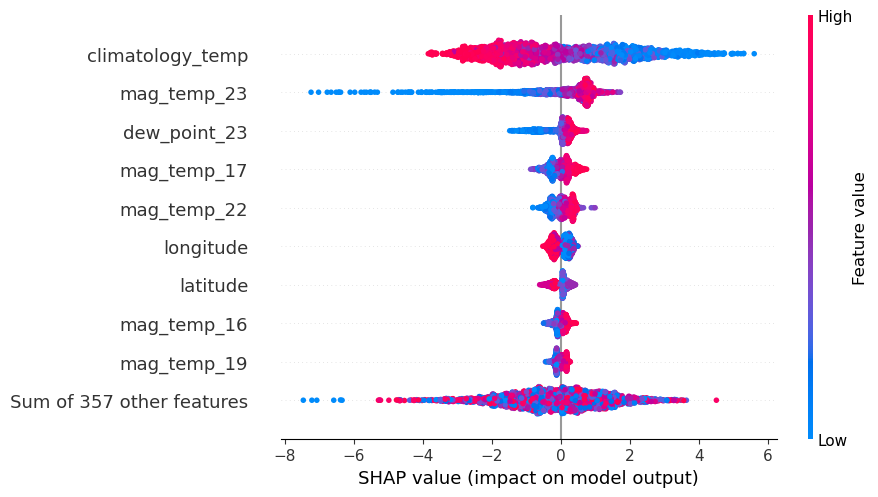

In [33]:
import shap
import matplotlib.pyplot as plt

# 🎯 모델에 대한 SHAP Explainer 생성
explainer = shap.Explainer(final_model)

# 🔍 validation 데이터에 대한 SHAP 값 계산
shap_values = explainer(X_val)

# 🐝 변수 중요도 시각화 (Beeswarm plot)
shap.plots.beeswarm(shap_values)

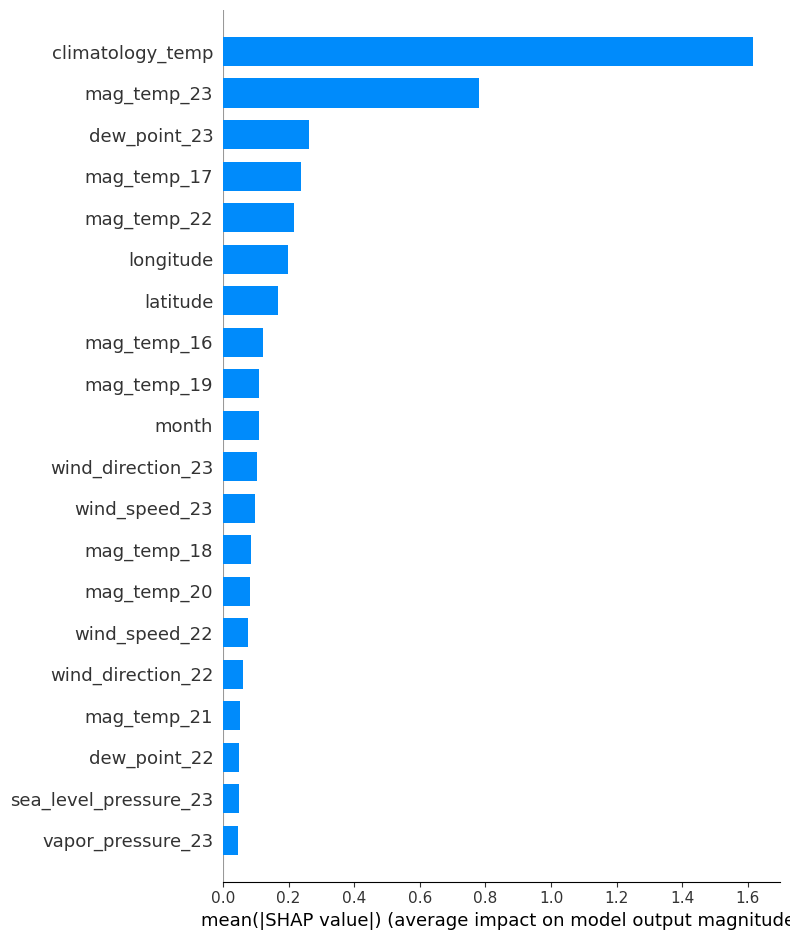

In [35]:
shap.summary_plot(shap_values.values, X_val, plot_type="bar")

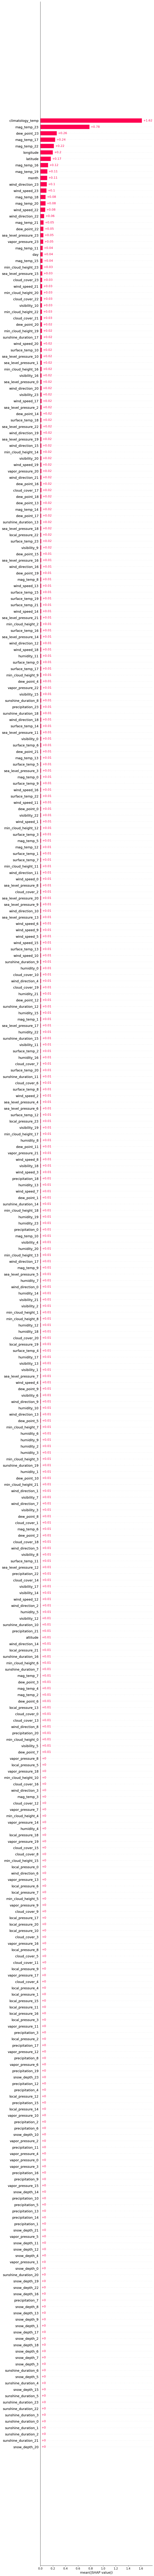

In [37]:
shap.plots.bar(shap_values, max_display=shap_values.shape[1])

In [39]:
import numpy as np
import pandas as pd

# SHAP 값 배열 추출 (Explanation 객체 → numpy array)
shap_array = shap_values.values  # 👈 이거 추가!

# 1. 변수별 평균 SHAP값 계산 (절댓값 기준)
mean_abs_shap = np.abs(shap_array).mean(axis=0)

# 2. 중요도 데이터프레임 만들기
importance_df = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': mean_abs_shap
}).sort_values(by='mean_abs_shap', ascending=False)

# 3. 누적합 기준으로 95% 이상 되는 feature 추리기
importance_df['cumsum'] = importance_df['mean_abs_shap'].cumsum()
importance_df['cumsum_pct'] = importance_df['cumsum'] / importance_df['mean_abs_shap'].sum()

# 4. 상위 95% 중요 변수만 필터링
top_features = importance_df[importance_df['cumsum_pct'] <= 0.99]['feature'].tolist()

# 🎉 최종 중요 변수만 남긴 X (선택사항)
X_top = X[top_features]

print(f"📊 상위 95% 중요 변수 개수: {len(top_features)}개")

📊 상위 95% 중요 변수 개수: 290개


In [49]:
final_model = XGBRegressor(
    n_estimators=665,
    learning_rate=0.07468890154873875,
    max_depth=8,
    random_state=29,
    min_child_weight=10,
    tree_method='hist'
)

# 💥 전부 다 학습에 씀
final_model.fit(X_top, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.07468890154873875, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=665, n_jobs=None,
             num_parallel_tree=None, ...)

In [51]:
y_pred = final_model.predict(X_top)

rmse = mean_squared_error(y, y_pred, squared=False)
print(f'✅ 검증 RMSE: {rmse:.4f} °C')

✅ 검증 RMSE: 0.0709 °C


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [53]:
test_top = test[top_features]

In [55]:
prediction = final_model.predict(test_top)
submission_df = pd.DataFrame({'target':prediction})
submission_df.to_csv('yesShap_8.csv',index=True)